# Sampleo de parámetros del modelo VAR

La finalidad del primer sampleo es encontrar los parámetros para el modelo Vectorial Autoregresivo. Si consideramos una serie de tiempo de dimensión $K$, $y_{1},..., y_{T}$ en donde $y_{t}=(y_{1t}, ..., y_{Kt})$ es un vector de dimensión $K$, entonces el modelo VAR$(p)$ queda definido como (Lutkepohl , 2005):

$$y_{t}=\upsilon + A_{1}y_{t-1}+...+A_{p}y_{t-p}+u_{t} \quad (1)$$

En donde $\upsilon=(\upsilon_{1},...,\upsilon_{K})$ es el vector de interceptos ($K\times1$), $A_{i}$ son los coeficientes matriciales ($K\times K$) y finalmente $u_{t}$ es un ruido blanco de covarianza $\Sigma_{u}$, la cual es de dimensión ($K\times K$). En este caso, asumimos el ruido blanco como una normal multivariada de $K$ dimensiones. Además, definimos la matriz $A=(A_{1}, ..., A_{p})$ en base a los coeficientes matriciales $A_{i}$.

De acuerdo a la definición (1), es posible definir la función de log-likelihood correspondiente (Lutkephol, 2005):

$$ -\frac{KT}{2}ln \, 2\pi - \frac{T}{2} ln \, |\Sigma_{u}| - \frac{1}{2} tr \left[ (Y^0 - AX)' \Sigma_{u}^{-1} (Y^0 - AX) \right] \quad (2)$$
$$Y^0 = (y_{1} - \upsilon , ..., y_{T} - \upsilon)$$
$$X = (Y_0, \ldots, Y_{T-1}) $$
$$ Y_t = (y_{t} - \upsilon, \ldots, y_{t-p+1} - \upsilon)' \quad \forall t = 1,\ldots,T $$

donde $T$ corresponde al numero de observaciones, $tr$ corresponde a la traza de la matriz, y las matrices $Y^0,X$ son obtenidas a partir de las observaciones del proceso $y_{t}$ del modelo VAR. De esta forma, y asumiendo una prior uniforme, es posible definir la distribución posterior de los parámetros $A,\Sigma_u$ en base a (2), a partir de la cual podemos obtener muestras por métodos de Markov Chain Monte Carlo (MCMC).

Para capturar la incertidumbre en los parámetros $A,\Sigma_u$, generamos muestras mediante el método de Gibbs Sampling. En específico, se consideran las distribuciones de probabilidad para la matriz $A$ dadas por:

$$p(A_{ijk}|A_{-i-j-k}, \Sigma_{u}, D), \forall i,j,k. 1\leq i \leq p \wedge 1\leq j, k \leq K$$

en donde $i$ representa a un coeficiente en específico de $A_i$ de acuerdo a la eq. (1). Los indices $j, k$ representan una entrada en específico de la matriz coeficiente $A_i$ de dimensión $K\times K$.

Además, para la matriz de covarianza del ruido blanco $\Sigma_{u}$, se considera la distribución de probabilidad dada por:

$$p({\Sigma_{u}}_{ij}|A, {\Sigma_{u}}_{-i-j}, D), \forall i,j. 1 \leq i, j \leq K $$

en donde $i,j$ representa una entrada en específico de la matriz $\Sigma_{u}$. 

Lo anterior, da lugar a una actualización continua de las matrices $A,\Sigma_{u}$, en donde se fijan todas las entradas de las matrices excepto una, la cual es sampleada según alguna distribución $q$ predefinida utilizando Metropolis Hastings. Hasta el momento hemos elegido $q$ ser una normal univariada.

Cabe destacar que para cada sampleo univariado se revisa si es que el nuevo parámetro (en conjunto con los anteriores) cumplen con ciertas restricciones. Para la matriz $A$ se debe cumplir que esta sea estable y $\Sigma_{u}$ debe ser semidefinida positiva (porque se trata de una normal multivariada), por lo tanto, no se acepta el sampleo de un nuevo parámetro hasta que se cumplen estas condiciones.

En la implementación definimos una variable $\theta$ que contiene todos los parámetros correspondientes a las matrices $A$ y $\Sigma_{u}$ en un vector. De esta manera pudimos ir iterando por cada parámetro para ir sampleándolos de manera más simple.

A medida que realizábamos experimentos, nos dimos cuenta que los parámetros sampleados no variaban mucho, por lo que decidimos incluir Simulated Annealing para abarcar un mayor espectro de las funciones de probabilidades condicionales definidas anteriormente.

# Procedimiento del sampleo

Para obtener una distribución de los parámetros del modelo VAR, tuvimos que ocupar varios computadores debido al gran tiempo que demoraba el sampleo. El código utilizado para realizar este procedimiento puede encontrarse en **parameters_generation.py**. La obtención $1000$ muestras demoró alrededor de 8 horas.

Debido a que la toma de muestras demoraba mucho, decidimos realizar muestras de un modelo VAR con $p=1$, es decir, tomando en cuenta solo el tiempo anterior para pronosticar el próximo valor de la velocidad del viento. Sin embargo, es posible extender el modelo desarrollado en este proyecto para un $p$ mayor.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from forecast import simulate_traj, process_traj
from utils import curve_fit, PL5

In [2]:
# Load generated samples.
SAMPLES_PATH = '/home/chrisams/Documents/datasets/data_TAIM/samples_1_1000.pickle'
with open(SAMPLES_PATH, 'rb') as f:
    samples = pickle.load(f)

A_samples = [None] * len(samples)
U_samples = [None] * len(samples)

for i in range(len(samples)):
    A_samples[i] = samples[i][0]
    U_samples[i] = samples[i][1]

# File names used to sample.
PLANT_NAMES = [
    'd05b_2010-06-19_2018-03-05.csv',
    'd01_2009-07-12_2018-01-17.csv',
]

# Load stats (mean and std of files).
STATS_PATH = '/home/chrisams/Documents/datasets/data_TAIM/stats.pickle'
with open(STATS_PATH, 'rb') as f:
    stats = pickle.load(f)

# Gráfica de la curva de potencia

El siguiente código busca los parámetros de una curva de potencia que se adaptan a los datos de potencia generada según la velocidad del viento (medidos experimentalmente).

In [3]:
POWER_DATA_PATH = '/home/chrisams/Documents/datasets/data_TAIM/data_power.csv'

power_data_csv = pd.read_csv(POWER_DATA_PATH) # Speed-PowerGeneration data.
xdata = power_data_csv['Wind speed (m/s)'].values
ydata = power_data_csv['Power (kW)'].values

fit_out = curve_fit(PL5, xdata, ydata, maxfev=10000)

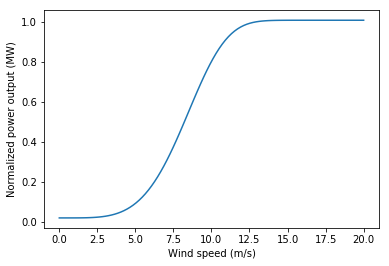

In [4]:
# Plot of the power curve obtained.
u = np.linspace(0.01,20,num=100)
a = fit_out[0][0]
b = fit_out[0][1]
c = fit_out[0][2]
d = fit_out[0][3]
g = fit_out[0][4]
plt_out = PL5(u,a,b,c,d,g)
plt.plot(u,plt_out)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Normalized power output (MW)')
plt.show()

# Predicción de la potencia generada

En la entrega anterior detallamos los pasos que se hacían para llegar a predecir la potencia generada, sin embargo, ahora todo está contenido en el siguiente código. 

In [5]:
# Simulation of wind speed
x0 = np.transpose(np.matrix([[0.3, 0.4]]))  #starting point (value from which forecast are made)
horizon = 4    #how many steps-ahead the forecast are made
n_samples = 1000  #how many forecast/trajectories are generated for EACH sampled VAR parameter
n_rnd_param = len(samples) 
cap_wind = 3 # wind plant capacity (eg. 3MW)
cut_speed = 20 # Speed where generator stop working for security.
offset_0 = np.array([stats[PLANT_NAMES[0]]['mean'],stats[PLANT_NAMES[1]]['mean']])
offset_1 = offset_0[:,None,None] #(3,) -> (3,1,1)
std_a = np.array([stats[PLANT_NAMES[0]]['std'],stats[PLANT_NAMES[1]]['std']])
std = std_a[:, None, None]
ql = 5
qu = 95


#sampl_traj = simulate_traj(A_samples, U_samples, x0, offset_1, std, n_samples, horizon,\
#                           n_rnd_param, cap_wind, cut_speed, a, b, c, d, g)
#list_mix = process_traj(sampl_traj, ql, qu, n_samples, n_rnd_param, horizon, False)
#
#print("Resulting mean and quantiles")
#print(list_mix) 

/home/chrisams/repos/TAIM/utils.py:442: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(np.zeros(Kv),CovU,size=n_samples)


Resulting mean and quantiles
[array([4.75352245, 4.53250132, 4.38755358, 4.27150198]), array([2.95322449, 2.12236002, 1.57266073, 1.17334706]), array([5.94941286, 6.01241693, 6.03106519, 6.03771674])]


In [ ]:
## Ficticious data parameters
n_data = 10 #number of hours in which forecasts are made (different from horizon)
#x_data = np.random.rand(3,n_data) + offset_0[:,None] #rnd matrix with numbers between [0,1)
K_dim  = A.shape[0]

## Generate ficticious data from which sample (x_data is zero mean)
x_data = np.zeros((3,n_data)) #it is assummed previous value was zero
for t in range(1,n_data):
    x0_aux = x_data[:,t-1]
    fc_wind = ut.sim_wind(A,U,x0_aux[:,None],1,1)
    x_data[:,t] = fc_wind.flatten() 

## 'Real' total generation from data
wind_data = x_data + offset_0[:,None]# here offset is added so real total generation is consistent
pow_data = ut.power_curve(wind_data,cap_wind,cut_speed,a,b,c,d,g) #apply power curve
gen_data = np.sum(pow_data,axis=0) #sum for all wind farms

## Forecasts
mean_t = np.zeros((n_data,horizon)) #mean
ql_t = np.zeros((n_data,horizon)) #lower quantile
qu_t = np.zeros((n_data,horizon)) #upper quantile

for t in range(n_data):
    #get previous point from which forecast is made
    x0 = x_data[:,t]
    x0 = x0[:,None]
    
    #make forecast
    sampl_traj = fc.simulate_traj(A_noise,U_noise,x0,offset_1,n_samples,horizon,n_rnd_param,cap_wind,cut_speed, a, b, c, d, g)
    list_mix = fc.process_traj(sampl_traj,ql,qu,n_samples,n_rnd_param,horizon,False)
    mean_t[t,:] = list_mix[0]
    ql_t[t,:] = list_mix[1]
    qu_t[t,:] = list_mix[2]
    
print("Only 1 step ahead forecasts are shown")
plt.figure()
plt.plot(range(n_data),gen_data,color='green') #'real' generation'
plt.plot(range(1,n_data),mean_t[:-1,0],color='blue') #mean forecast
plt.plot(range(1,n_data),ql_t[:-1,0],color='red') #interval forecast
plt.plot(range(1,n_data),qu_t[:-1,0],color='red') 
plt.show()